# General 
* Docs: https://gpytorch.readthedocs.io/en/latest/index.html
* GIT: https://github.com/cornellius-gp/gpytorch

## GPyTorch Regression Tutorial
### Introduction
Use simple example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function
\begin{equation*}
y = \sin(2\pi x) + \epsilon\\
\epsilon \sim \mathcal{N}(0,0.2)
\end{equation*}
with 11 training examples, and testing on 51 test examples.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data
Regularly spaced points on [0,1] and add Gaussian noise to training labels

In [2]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

### Set up model
In contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide the tools necessary to quickly construct one. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary.

For most GP regression models, you will need to construct the following GPyTorch objects:

* A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.
* A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.
* A Mean - This defines the prior mean of the GP. If you don't know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.
* A Kernel - This defines the prior covariance of the GP. If you don't know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start.
* A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.


#### The GP Model
Components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:
* An __init__ method: Constructs whatever objects are necessary for the model's forward method.
* A forward method: Takes in $n \times d$ data x, returns a MultivariateNormal with the prior mean and covariance evaluated at x. In other words: Return vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP.
This leaves flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly: $self.covar_{module} = ScaleKernel(RBFKernel() + WhiteNoiseKernel())$

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

#### Model modes
Like most PyTorch modules, the ExactGP has a .train() and .eval() mode.

### Training the model 
Use Type-II MLE (Maximum Likelihood Estimation) to train the hyperparameters of the Gaussian process.
* Core training loop is written by the user
* GPyTorch uses the standard PyTorch optimizers from $torch.optim$, and all trainable parameters of the model should be of type $torch.nn.Parameter$

Basic components for the standard PyTorch training loop:
* Zero all parameter gradients
* Call the model and compute the loss
* Call backward on the loss to fill in gradients
* Take a step on the optimizer
This flexibility enables the user to save parameters at each step of the training or use different learning rates for each parameter.

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: -0.191   log_lengthscale: -1.206   log_noise: -3.474
Iter 2/50 - Loss: -0.193   log_lengthscale: -1.293   log_noise: -3.572
Iter 3/50 - Loss: -0.190   log_lengthscale: -1.274   log_noise: -3.527
Iter 4/50 - Loss: -0.187   log_lengthscale: -1.219   log_noise: -3.470
Iter 5/50 - Loss: -0.188   log_lengthscale: -1.201   log_noise: -3.439
Iter 6/50 - Loss: -0.192   log_lengthscale: -1.209   log_noise: -3.449
Iter 7/50 - Loss: -0.189   log_lengthscale: -1.209   log_noise: -3.479
Iter 8/50 - Loss: -0.190   log_lengthscale: -1.208   log_noise: -3.509
Iter 9/50 - Loss: -0.191   log_lengthscale: -1.226   log_noise: -3.530
Iter 10/50 - Loss: -0.192   log_lengthscale: -1.243   log_noise: -3.531
Iter 11/50 - Loss: -0.191   log_lengthscale: -1.264   log_noise: -3.529
Iter 12/50 - Loss: -0.193   log_lengthscale: -1.297   log_noise: -3.525
Iter 13/50 - Loss: -0.191   log_lengthscale: -1.309   log_noise: -3.511
Iter 14/50 - Loss: -0.188   log_lengthscale: -1.308   log_noise: -3.491
I

### Make predictions with the model
Simply put the model and likelihood in eval mode, and call both modules on the test data. A trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:
* f_preds = model(test_x)
* y_preds = likelihood(model(test_x))


* f_mean = f_preds.mean
* f_var = f_preds.variance
* f_covar = f_preds.covariance_matrix
* f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

### Plot the model fit
n the next cell, we plot the mean and confidence region of the Gaussian process model. The confidence_region method is a helper method that returns 2 standard deviations above and below the mean.

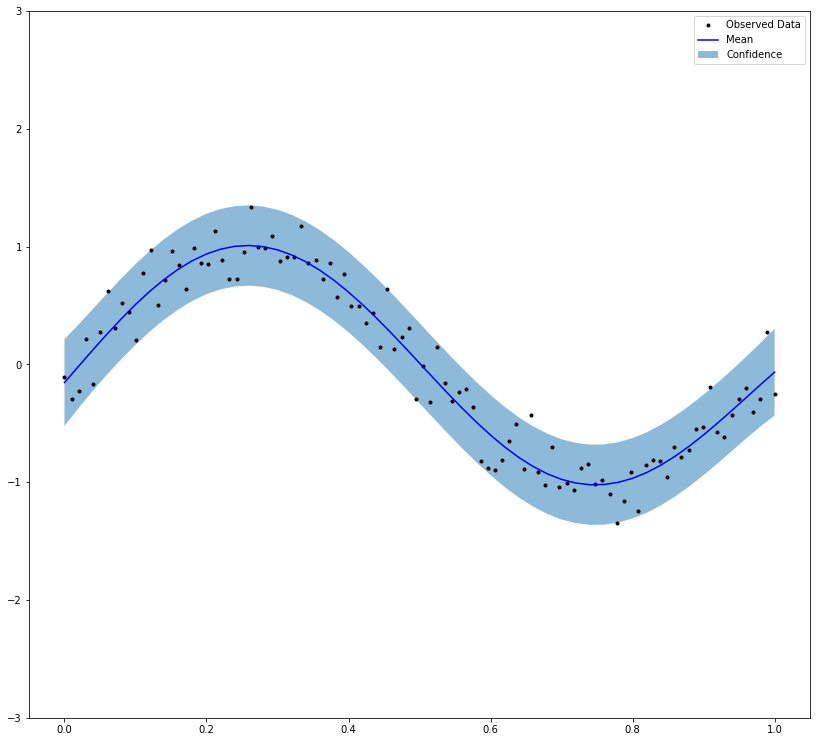

In [14]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(14, 13))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])